In [1]:
# %pylab nbagg
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from sys import path

path.append("~/ownCloud/analysis_scripts/")
import slurm_lib as sl

In [2]:
# Loading of a few libraries

import time

start_time = time.time()
import os
import fabio
import pyFAI

print(pyFAI.version)
from pyFAI.goniometer import (
    GeometryTransformation,
    GoniometerRefinement,
    Goniometer,
    ExtendedTransformation,
)
from pyFAI.gui import jupyter
import glob
from collections import OrderedDict, namedtuple

try:
    import numexpr
except ImportError:
    numexpr = None
import h5py

print(h5py.__version__)
import hdf5plugin
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

matplotlib.rcParams["figure.figsize"] = [10, 10]

0.20.0
3.3.0


In [3]:
# set the calibration: scans --> 3 images at different distances, scan_base --> the bliss 'datset', h5 --> h5 file with the scans.

scans77 = [1, 2, 3]
scan_base77 = "middle_distance_calib_77keV"
h577 = h5py.File(
    "/data/id31/inhouse/ihma5017/id31/middle_distance/ihma5017_middle_distance.h5"
)

In [4]:
# Definition of the geometry translation function:

et = ExtendedTransformation(
    param_names=[
        "dist_scale",
        "dist_offset",
        "poni1",
        "poni1_scale",
        "poni2",
        "poni2_scale",
        "rot1",
        "rot2",
        "energy",
    ],
    pos_names=["dist"],
    dist_expr="dist_scale * dist + dist_offset",
    poni1_expr="dist * poni1_scale + poni1",
    poni2_expr="dist * poni2_scale + poni2",
    rot1_expr="rot1",
    rot2_expr="rot2",
    rot3_expr="0",
    wavelength_expr="hc*1e-10/energy",
)

In [5]:
# Definition of the function reading the detector position from the header of the h5file.
def get_distance(metadata):  # metadata = (h5, scanno, scan_base)
    """finds the cncx position"""
    h5, scanno, scan_base = metadata
    path = scan_base + "_" + str(scanno) + ".1/instrument/positioners/cncx"
    return h5[path][()] / 1000


# Definition of the function reading the energy.
def get_energy(h5, scanno, imno, scan_base):
    """finds the cncx position"""
    path = scan_base + "_" + str(scanno) + ".1/instrument/positioners/energy"
    print(path)
    return h5[path][()]


def get_imagedata(h5, scanno, imno, scan_base):
    """Finds image data"""
    path = scan_base + "_" + str(scanno) + ".1/measurement/p3"
    return h5[path][:]

### Calibration for point 0 (77keV)

In [7]:
# Definition of the detector, the calibrant and extraction of the wavelength and estimate for the poni (from rough calibration)
pilatus = pyFAI.detector_factory("Pilatus2MCdTe")
CeO277 = pyFAI.calibrant.get_calibrant("CeO2")
energy77 = get_energy(h577, scans77[0], 0, scan_base77)
wavelength77 = 1e-10 * pyFAI.units.hc / energy77
poni1 = 0.2809669556278185
poni2 = 0.12004674650712045
print("Wavelength:", wavelength77)
print("Energy", energy77)
print("Poni1:", poni1)
print("Poni2:", poni2)
CeO277.wavelength = wavelength77
print(CeO277)

middle_distance_calib_77keV_1.1/instrument/positioners/energy
Wavelength: 1.610184395236367e-11
Energy 77.0
Poni1: 0.2809669556278185
Poni2: 0.12004674650712045
CeO2 Calibrant with 41 reflections at wavelength 1.610184395236367e-11


In [11]:
# Definition of the geometry refinement: the parameter order is the same as the param_names

"""
param = {"dist_scale":1,
         "dist_offset":1.0124069709666417-0.95,
         "poni1":poni1,
         "poni1_scale":0,
         "poni2":poni2,
         "poni2_scale":0,
         "rot1":-0.005441251425385605,
         "rot2":-0.0038255325358075927,
         "energy":energy}
"""

param = [
    9.99848695e-01,
    5e-02,
    2.78409059e-01,
    8.33458427e-04,
    1.24879731e-01,
    -3.03700411e-03,
    -4.00043903e-03,
    -2.08734899e-03,
    7.70000073e01,
]

gonioref = GoniometerRefinement(
    param,  # initial guess
    pos_function=get_distance,
    trans_function=et,
    detector=pilatus,
    wavelength=wavelength77,
)
print("Empty refinement object:")
print(gonioref)

Empty refinement object:
GoniometerRefinement with 0 geometries labeled: .


In [8]:
param2 = {
    "dist_scale": gonioref.param[0],
    "dist_offset": gonioref.param[1],
    "poni1": gonioref.param[2],
    "poni1_scale": gonioref.param[3],
    "poni2": gonioref.param[4],
    "poni2_scale": gonioref.param[5],
    "rot1": gonioref.param[6],
    "rot2": gonioref.param[7],
    "energy": energy,
}

In [35]:
param = {
    "dist_scale": gonioref2.param[0],
    "dist_offset": gonioref2.param[1],
    "poni1": gonioref2.param[2],
    "poni1_scale": gonioref2.param[3],
    "poni2": gonioref2.param[4],
    "poni2_scale": gonioref2.param[5],
    "rot1": gonioref2.param[6],
    "rot2": gonioref2.param[7],
    "energy": energy77,
}

In [8]:
param = {
    "dist_scale": 1,
    "dist_offset": 0.06,
    "poni1": poni1,
    "poni1_scale": 0,
    "poni2": poni2,
    "poni2_scale": 0,
    "rot1": -0.007,
    "rot2": -0.003,
    "energy": energy77,
}

In [11]:
param = [
    9.99848695e-01,
    -1.96508049e-02,
    2.78409059e-01,
    8.33458427e-04,
    1.24679731e-01,
    -3.03700411e-03,
    -4.00043903e-03,
    -2.08734899e-03,
    7.70000073e01,
]

In [12]:
# Let's populate the goniometer refinement object with all control point files:

for scanno in scans77:
    base = scan_base77 + "_" + str(scanno)
    fimg = get_imagedata(h577, scanno, 0, scan_base77)
    ng = gonioref.new_geometry(
        os.path.basename(base),
        image=fimg,
        metadata=(h577, scanno, scan_base77),
        calibrant=CeO277,
    )
    ng.extract_cp(max_rings=25, pts_per_deg=3)

print("Filled refinement object:")
print(gonioref)
print(os.linesep + "\tLabel \t Distance")
for k, v in gonioref.single_geometries.items():
    print(k, v.get_position())

Filled refinement object:
GoniometerRefinement with 3 geometries labeled: middle_distance_calib_77keV_1, middle_distance_calib_77keV_2, middle_distance_calib_77keV_3.

	Label 	 Distance
middle_distance_calib_77keV_1 0.95
middle_distance_calib_77keV_2 0.85
middle_distance_calib_77keV_3 1.05


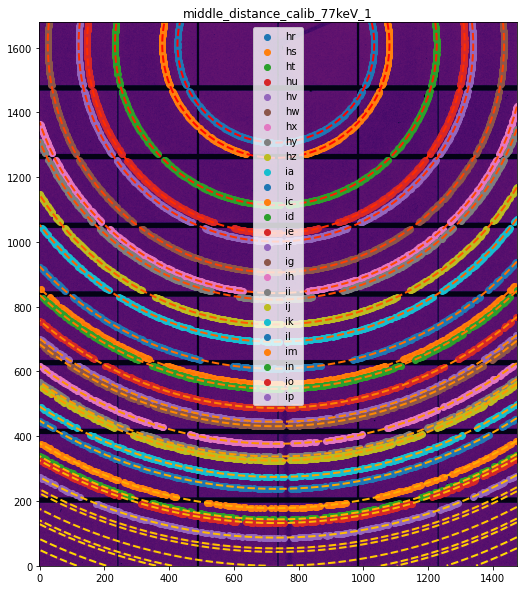

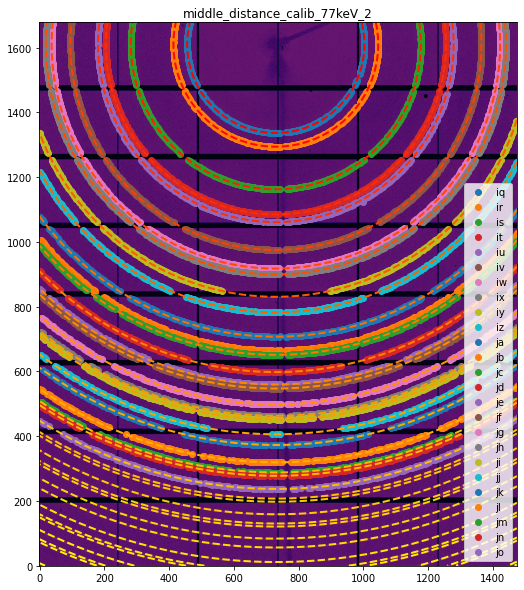

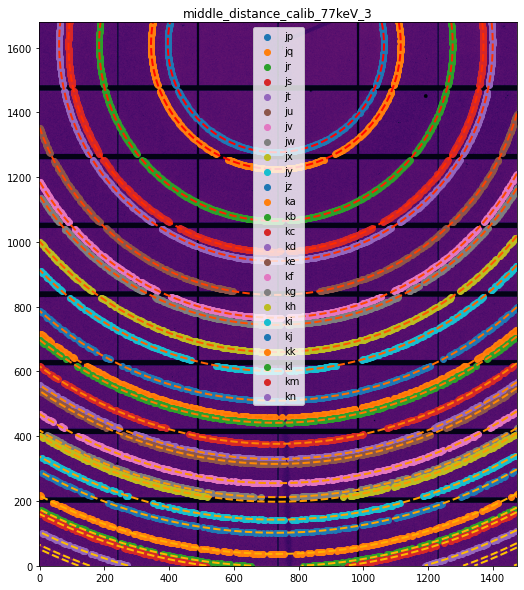

In [61]:
for sg in gonioref.single_geometries.values():
    fig = jupyter.display(sg=sg)
    # print(fig.rect)

In [62]:
# Initial refinement of the translation table model

print(CeO277)
# gonioref.param = [-0.02, poni1,0, poni2,0,0,0, energy]
print(gonioref.param)
gonioref.set_bounds("dist_scale", 0.95, 1.05)
gonioref.set_bounds("dist_offset", -0.1, 0.1)
gonioref.set_bounds("energy", 76, 78)
gonioref.set_bounds("poni1", -8e-1, 8e-1)
gonioref.set_bounds("poni2", -8e-1, 8e-1)
gonioref.set_bounds("poni1_scale", -0.1, 0.1)
gonioref.set_bounds("poni2_scale", -0.1, 0.1)
gonioref.set_bounds("rot1", -1e-1, 1e-1)
gonioref.set_bounds("rot2", -1e-1, 1e-1)
print(gonioref.bounds)
gonioref.refine2(method="slsqp")
# gonioref.refine2(method="L-BFGS-B")
# gonioref.set_bounds("dist_offset",-1e-2, 1e-2)

# print(gonioref.bounds)
# gonioref.refine2(method="slsqp")

CeO2 Calibrant with 41 reflections at wavelength 1.610184393986516e-11
[ 1.00097189e+00  6.18327989e-02  2.76873398e-01  1.77385427e-03
  1.25149147e-01 -3.58496085e-03 -3.77541253e-03 -1.46413761e-03
  7.70000001e+01]
[(0.95, 1.05), (-0.1, 0.1), (-0.8, 0.8), (-0.1, 0.1), (-0.8, 0.8), (-0.1, 0.1), (-0.1, 0.1), (-0.1, 0.1), (76, 78)]
Cost function before refinement: 3.5362210912333082e-09
[ 1.00097189e+00  6.18327989e-02  2.76873398e-01  1.77385427e-03
  1.25149147e-01 -3.58496085e-03 -3.77541253e-03 -1.46413761e-03
  7.70000001e+01]
     fun: 3.3803820256965714e-09
     jac: array([ 3.03358649e-07,  3.26638847e-07, -1.31462642e-07, -4.35041914e-09,
       -2.12332071e-07,  3.03477841e-07,  7.46711206e-08,  2.28407077e-07,
       -3.70287739e-09])
 message: 'Optimization terminated successfully'
    nfev: 72
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([ 1.00106362e+00,  6.19149513e-02,  2.76975944e-01,  1.76836744e-03,
        1.25201839e-01, -3.63716042e-03, -3.7

array([ 1.00106362e+00,  6.19149513e-02,  2.76975944e-01,  1.76836744e-03,
        1.25201839e-01, -3.63716042e-03, -3.77958247e-03, -1.52694858e-03,
        7.69999986e+01])

In [16]:
print(gonioref.bounds)
print(gonioref.param)
print(et)
print(CeO277)
gonioref.fit_wavelength

[(0.95, 1.05), (-0.1, 0.1), (-0.8, 0.8), (-0.1, 0.1), (-0.8, 0.8), (-0.1, 0.1), (-0.1, 0.1), (-0.1, 0.1), (76, 78)]
[ 1.00097603e+00  6.18373067e-02  2.76939648e-01  1.74345663e-03
  1.25204095e-01 -3.62690897e-03 -3.72943453e-03 -1.49704032e-03
  7.69999865e+01]
ExtendedTransformation with param: ('dist_scale', 'dist_offset', 'poni1', 'poni1_scale', 'poni2', 'poni2_scale', 'rot1', 'rot2', 'energy') and pos: ('dist',)
    dist= dist_scale * dist + dist_offset
    poni1= dist * poni1_scale + poni1
    poni2= dist * poni2_scale + poni2
    rot1= rot1
    rot2= rot2
    rot3= 0
    wavelength= hc*1e-10/energy
CeO2 Calibrant with 41 reflections at wavelength 1.610184677871986e-11


True

MultiGeometry integrator with 3 geometries on (1.75, 12) radial range (q_A^-1) and (-180, 180) azimuthal range (deg)


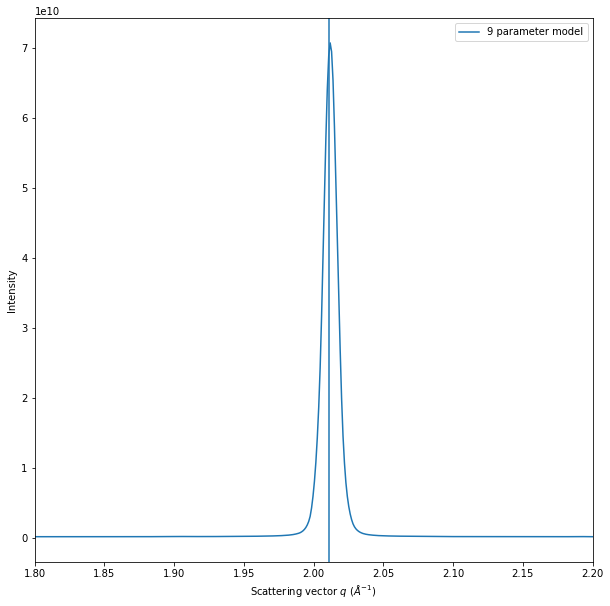

In [63]:
# Integration of all images with the second model
distances = [get_distance((h577, scanno, scan_base77)) for scanno in scans77]
multigeo2 = gonioref.get_mg(distances)
multigeo2.radial_range = (1.75, 12)
multigeo2.unit = pyFAI.units.to_unit("q_A^-1")
# multigeo2.unit=pyFAI.units.to_unit("2th")
print(multigeo2)
res2 = multigeo2.integrate1d(
    [get_imagedata(h577, scanno, 0, scan_base77) for scanno in scans77], 10000
)

# Display the result, zooming on the two first rings
fig, ax = plt.subplots()
# ax.plot(*res)
# ax.plot(*res, label="4-parameter model")
ax.plot(*res2, label="9 parameter model")
ax.axvline(x=4 * np.pi * np.sin(CeO277.get_2th()[0] / 2) / CeO277.wavelength / 1e10)
ax.set_ylabel("Intensity")
ax.set_xlim(1.8, 2.2)
# ax.set_title("Zoom on the two first rings")
ax.set_xlabel(res2.unit.label)
ax.legend()

### Calibration for point 24 (78.44 keV)

In [20]:
scans78 = [1, 2, 3]
scan_base78 = "middle_distance_edge_calib_7836"
h578 = h5py.File(
    "/data/id31/inhouse/ihma5017/id31/middle_distance_edge/ihma5017_middle_distance_edge.h5"
)

In [22]:
pilatus = pyFAI.detector_factory("Pilatus2MCdTe")
CeO278 = pyFAI.calibrant.get_calibrant("CeO2")
energy78 = get_energy(h578, scans78[0], 0, scan_base78)
wavelength78 = 1e-10 * pyFAI.units.hc / energy78
print("Wavelength:", wavelength78)
print("Energy", energy78)
CeO278.wavelength = wavelength78
print(CeO278)

middle_distance_edge_calib_7836_1.1/instrument/positioners/energy
Wavelength: 1.5822391541449395e-11
Energy 78.35996101373358
CeO2 Calibrant with 41 reflections at wavelength 1.5822391541449395e-11


In [64]:
param2 = {
    "dist_scale": gonioref.param[0],
    "dist_offset": gonioref.param[1],
    "poni1": gonioref.param[2],
    "poni1_scale": gonioref.param[3],
    "poni2": gonioref.param[4],
    "poni2_scale": gonioref.param[5],
    "rot1": gonioref.param[6],
    "rot2": gonioref.param[7],
    "energy": energy78,
}

gonioref2 = GoniometerRefinement(
    param2,  # initial guess
    pos_function=get_distance,
    trans_function=et,
    detector=pilatus,
    wavelength=wavelength78,
)
print("Empty refinement object:")
print(gonioref2)

Empty refinement object:
GoniometerRefinement with 0 geometries labeled: .


In [21]:
"""
param2 = {"dist_scale":gonioref.param[0],
         "dist_offset":gonioref.param[1],
         "poni1":gonioref.param[2],
         "poni1_scale":gonioref.param[3],
         "poni2":gonioref.param[4],
         "poni2_scale":gonioref.param[5],
         "rot1":gonioref.param[6],
         "rot2":gonioref.param[7],
         "energy":energy}
"""

In [65]:
# Let's populate the goniometer refinement object with all control point files:

for scanno in scans78:
    base = scan_base78 + "_" + str(scanno)
    fimg = get_imagedata(h578, scanno, 0, scan_base78)
    ng = gonioref2.new_geometry(
        os.path.basename(base),
        image=fimg,
        metadata=(h578, scanno, scan_base78),
        calibrant=CeO278,
    )
    ng.extract_cp(max_rings=25, pts_per_deg=3)

print("Filled refinement object:")
print(gonioref2)
print(os.linesep + "\tLabel \t Distance")
for k, v in gonioref2.single_geometries.items():
    print(k, v.get_position())

Filled refinement object:
GoniometerRefinement with 3 geometries labeled: middle_distance_edge_calib_7836_1, middle_distance_edge_calib_7836_2, middle_distance_edge_calib_7836_3.

	Label 	 Distance
middle_distance_edge_calib_7836_1 0.95
middle_distance_edge_calib_7836_2 0.85
middle_distance_edge_calib_7836_3 1.05


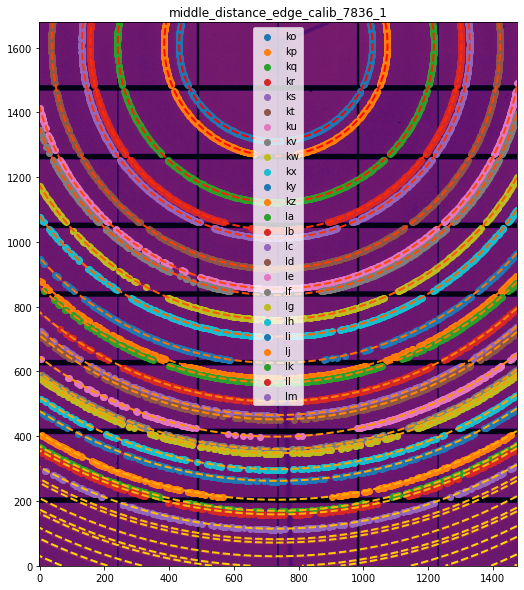

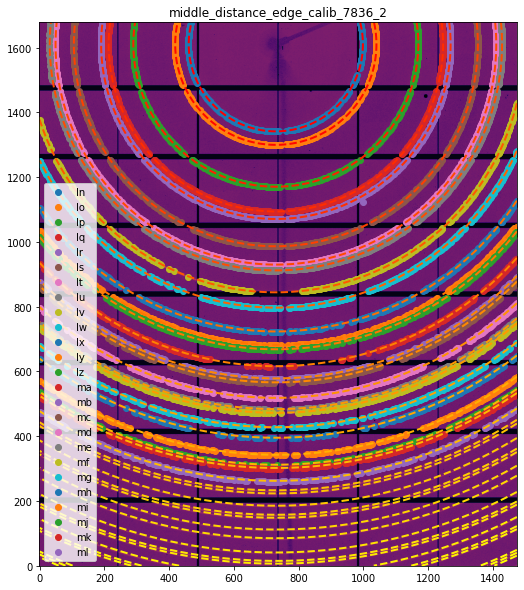

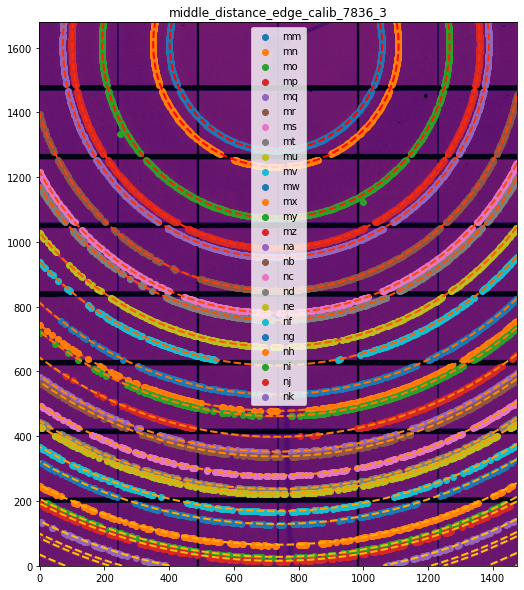

In [66]:
for sg in gonioref2.single_geometries.values():
    fig = jupyter.display(sg=sg)
    # print(fig.rect)

In [75]:
# Initial refinement of the translation table model

print(CeO278)
# gonioref.param = [-0.02, poni1,0, poni2,0,0,0, energy]
print(gonioref2.param)
gonioref2.set_bounds("dist_scale", gonioref.param[0] - 1e-1, gonioref.param[0] + 1e-1)
gonioref2.set_bounds("dist_offset", gonioref.param[1] - 1e-1, gonioref.param[1] + 1e-1)
gonioref2.set_bounds("poni1", gonioref.param[2] - 1e-1, gonioref.param[2] + 1e-1)
gonioref2.set_bounds("poni1_scale", gonioref.param[3] - 1e-1, gonioref.param[3] + 1e-1)
gonioref2.set_bounds("poni2", gonioref.param[4] - 1e-1, gonioref.param[4] + 1e-1)
gonioref2.set_bounds("poni2_scale", gonioref.param[5] - 1e-1, gonioref.param[5] + 1e-1)
gonioref2.set_bounds("rot1", gonioref.param[6] - 1e-1, gonioref.param[6] + 1e-1)
gonioref2.set_bounds("rot2", gonioref.param[7] - 1e-1, gonioref.param[7] + 1e-1)
gonioref2.set_bounds("energy", 78, 79)
gonioref2.refine2(method="slsqp")

CeO2 Calibrant with 41 reflections at wavelength 1.5822497303322536e-11
[ 1.00128537e+00  6.21596962e-02  2.77284561e-01  6.19246011e-03
  1.25230356e-01 -5.01413099e-03 -4.88810521e-03 -5.98603866e-03
  7.83594372e+01]
Cost function before refinement: 4.758585223072395e-09
[ 1.00128537e+00  6.21596962e-02  2.77284561e-01  6.19246011e-03
  1.25230356e-01 -5.01413099e-03 -4.88810521e-03 -5.98603866e-03
  7.83594372e+01]
     fun: 4.758585223072395e-09
     jac: array([ 8.28030693e-08,  1.03756652e-07,  7.40648889e-08,  4.00886782e-07,
        4.48196463e-07, -1.87649022e-07,  3.79634352e-07, -1.18970978e-07,
       -2.48687043e-09])
 message: 'Optimization terminated successfully'
    nfev: 10
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 1.00128537e+00,  6.21596962e-02,  2.77284561e-01,  6.19246011e-03,
        1.25230356e-01, -5.01413099e-03, -4.88810521e-03, -5.98603866e-03,
        7.83594372e+01])
Cost function after refinement: 4.758585223072395e-09
GonioPar

array([ 1.00128537e+00,  6.21596962e-02,  2.77284561e-01,  6.19246011e-03,
        1.25230356e-01, -5.01413099e-03, -4.88810521e-03, -5.98603866e-03,
        7.83594372e+01])

In [ ]:
gonioref2.set_bounds("dist_scale", 0.95, 1.05)
gonioref2.set_bounds("dist_offset", -0.05, 0.05)
gonioref2.set_bounds("energy", 78, 79)
gonioref2.set_bounds("poni1", -8e-1, 8e-1)
gonioref2.set_bounds("poni2", -8e-1, 8e-1)
gonioref2.set_bounds("poni1_scale", -0.1, 0.1)
gonioref2.set_bounds("poni2_scale", -0.1, 0.1)
gonioref2.set_bounds("rot1", -1e-1, 1e-1)
gonioref2.set_bounds("rot2", -1e-1, 1e-1)

In [94]:
gonioref2.set_bounds("dist_scale", gonioref.param[0] - 1e-9, gonioref.param[0] + 1e-9)
gonioref2.set_bounds("dist_offset", gonioref.param[1] - 1e-1, gonioref.param[1] + 1e-1)
gonioref2.set_bounds("poni1", gonioref.param[2] - 1e-1, gonioref.param[2] + 1e-1)
gonioref2.set_bounds("poni1_scale", gonioref.param[3] - 1e-9, gonioref.param[3] + 1e-9)
gonioref2.set_bounds("poni2", gonioref.param[4] - 1e-1, gonioref.param[4] + 1e-1)
gonioref2.set_bounds("poni2_scale", gonioref.param[5] - 1e-9, gonioref.param[5] + 1e-9)
gonioref2.set_bounds("rot1", gonioref.param[6] - 1e-9, gonioref.param[6] + 1e-9)
gonioref2.set_bounds("rot2", gonioref.param[7] - 1e-9, gonioref.param[7] + 1e-9)
gonioref2.set_bounds("energy", 78, 79)

MultiGeometry integrator with 3 geometries on (1.75, 12) radial range (q_A^-1) and (-180, 180) azimuthal range (deg)


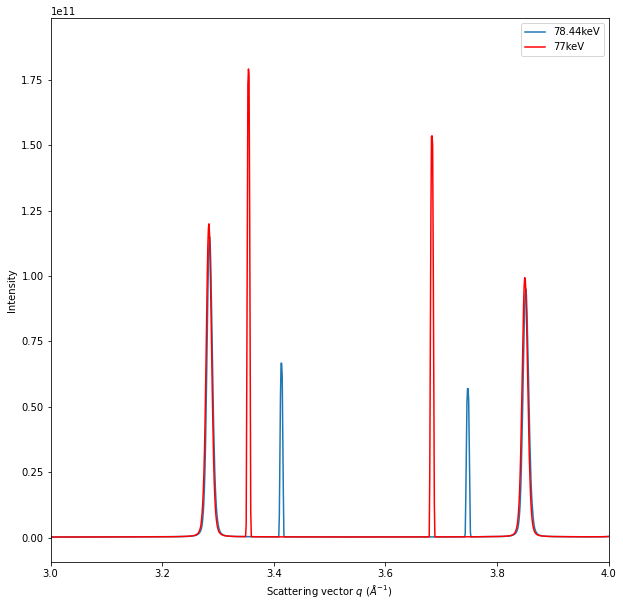

In [76]:
# Integration of all images with the second model
distances = [get_distance((h578, scanno, scan_base78)) for scanno in scans78]
multigeo3 = gonioref2.get_mg(distances)
multigeo3.radial_range = (1.75, 12)
multigeo3.unit = pyFAI.units.to_unit("q_A^-1")
print(multigeo3)
res3 = multigeo3.integrate1d(
    [get_imagedata(h578, scanno, 0, scan_base78) for scanno in scans78], 10000
)

# Display the result, zooming on the two first rings
fig, ax = plt.subplots()
# ax.plot(*res)
# ax.plot(*res, label="4-parameter model")
ax.plot(res3[0], res3[1], label="78.44keV")
ax.plot(res2[0], res2[1] * res3[1].max() / res2[1].max(), label="77keV", color="red")
ax.axvline(x=4 * np.pi * np.sin(CeO278.get_2th()[0] / 2) / CeO278.wavelength / 1e10)
ax.set_ylabel("Intensity")
ax.set_xlim(3, 4)
# ax.set_title("Zoom on the two first rings")
ax.set_xlabel(res3.unit.label)
ax.legend()

In [77]:
print(gonioref.param)
print(gonioref2.param)

[ 1.00106362e+00  6.19149513e-02  2.76975944e-01  1.76836744e-03
  1.25201839e-01 -3.63716042e-03 -3.77958247e-03 -1.52694858e-03
  7.69999986e+01]
[ 1.00128537e+00  6.21596962e-02  2.77284561e-01  6.19246011e-03
  1.25230356e-01 -5.01413099e-03 -4.88810521e-03 -5.98603866e-03
  7.83594372e+01]


In [31]:
print(gonioref.trans_function(pos=0.95, param=gonioref.param))
print(gonioref2.trans_function(pos=0.95, param=gonioref2.param))

ParamNT(dist=1.012764537560127, poni1=0.2785959317199438, poni2=0.12175853124296714, rot1=-0.003729434531492528, rot2=-0.0014970403233322065, rot3=0.0, wavelength=1.610184677871986e-11)
ParamNT(dist=1.012764539510127, poni1=0.278496287778985, poni2=0.12165715562994424, rot1=-0.0037294335314925283, rot2=-0.0014970413233322064, rot3=0.0, wavelength=1.5822391581020297e-11)


In [72]:
from pyFAI.io import ponifile

po = ponifile.PoniFile()
di = gonioref.trans_function(pos=0.95, param=gonioref.param)
di = {
    "detector": pilatus,
    "distance": di.dist,
    "poni1": di.poni1,
    "poni2": di.poni2,
    "rot1": di.rot1,
    "rot2": di.rot2,
    "rot3": di.rot3,
    "wavelength": di.wavelength,
}
print(di)
po.read_from_dict(di)
po.write(
    open(
        "/data/id31/inhouse/ihma5017/id31/capil-data_analysis/multidistance-calib_JD/77keV_950mm_2.poni",
        "w",
    )
)

{'detector': Detector Pilatus CdTe 2M	 PixelSize= 1.720e-04, 1.720e-04 m, 'distance': 1.012925392268427, 'poni1': 0.27865589259814183, 'poni2': 0.12174653646581915, 'rot1': -0.0037795824705767443, 'rot2': -0.0015269485782440748, 'rot3': 0.0, 'wavelength': 1.6101844235556542e-11}


In [71]:
di = gonioref2.trans_function(pos=0.95, param=gonioref2.param)
di = {
    "detector": pilatus,
    "distance": di.dist,
    "poni1": di.poni1,
    "poni2": di.poni2,
    "rot1": di.rot1,
    "rot2": di.rot2,
    "rot3": di.rot3,
    "wavelength": di.wavelength,
}
print(di)
po.read_from_dict(di)
po.write(
    open(
        "/data/id31/inhouse/ihma5017/id31/capil-data_analysis/multidistance-calib_JD/884keV_950mm_2.poni",
        "w",
    )
)

{'detector': Detector Pilatus CdTe 2M	 PixelSize= 1.720e-04, 1.720e-04 m, 'distance': 1.012925394218427, 'poni1': 0.283115204566112, 'poni2': 0.12051533413604945, 'rot1': -0.004845157273438179, 'rot2': -0.006019910150063786, 'rot3': 0.0, 'wavelength': 1.5822496693505353e-11}


In [ ]:
for imnum in 
pilatus = pyFAI.detector_factory("Pilatus2M")
CeO2 = pyFAI.calibrant.get_calibrant("CeO2")
energy = get_energy(h5, 24, 0, scan_base)
wavelength = 1e-10*pyFAI.units.hc/energy
CeO2.wavelength = wavelength

In [73]:
print(po.poni1)

0.2784101490928991


In [31]:
di.detector

AttributeError: 'dict' object has no attribute 'detector'

In [ ]:
gonioref.trans_function(pos=0.97, param=gonioref.param)